In [1]:
import scienceplots
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

plt.style.use("bright")
plt.rcParams["font.family"] = "sans-serif"

In [3]:
df_0 = pd.read_csv('precomputed_responses/qwen_1_7/online/arc_easy/responses_surrogate_token_probs_1_large.csv')
df_20 = pd.read_csv('precomputed_responses/imperfect_expert/20_label_corruption/responses.csv')
df_50 = pd.read_csv('precomputed_responses/imperfect_expert/50_label_corruption/responses.csv')
df_100 = pd.read_csv('precomputed_responses/imperfect_expert/100_label_corruption/responses.csv')

In [4]:
df_0 = df_0.iloc[100 :]
df_20 = df_20.iloc[100 :]
df_50 = df_50.iloc[100 :]
df_100 = df_100.iloc[100 :]

In [5]:
df = pd.DataFrame(
    {
        "system_risk_0" : df_0["system_risk"],
        "system_risk_20" : df_20["system_risk"],
        "system_risk_50" : df_50["system_risk"],
        "system_risk_100" : df_100["system_risk"],
    }
)

In [6]:
df

,system_risk_0,system_risk_20,system_risk_50,system_risk_100
100,0.811680,0.744278,0.707182,0.110445
101,0.137722,0.423903,0.735324,1.204670
102,0.141389,0.430193,0.733256,1.204371
103,1.182355,1.177911,0.777066,0.098702
104,0.100367,0.278227,0.723923,1.184750
...,...,...,...,...
995,0.152286,0.416693,0.568903,1.155860
996,0.595963,0.636985,0.564214,0.654163
997,0.112837,0.339243,0.570968,1.145361
998,0.104262,0.288947,0.573674,1.143175


In [9]:
def plot_risk_and_cumulative_risk(run_dir, df):
    """
    Plots system risk and cumulative system risk in two subplots next to each other.

    Args:
        run_dir (str): Directory to save the plot.
        df (DataFrame): DataFrame with system risk values over time.

    Saves:
        A plot with system risk and cumulative system risk as a PDF.
    """

    # Prepare the data
    colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
    color_0 = colors[0]  # First system color
    color_20 = colors[1]  # Second system color
    color_50 = colors[2]  # Fourth system color
    color_100 = colors[3]  # Third system color
    
    df_copy = df.copy()
    # Compute cumulative risk relative to the Dynamic system
    df_copy["cum_system_risk_0"] = (
        df_copy["system_risk_0"].cumsum() 
    )
    df_copy["cum_system_risk_20"] = (
        df_copy["system_risk_20"].cumsum() 
    ) 
    df_copy["cum_system_risk_50"] = (
        df_copy["system_risk_50"].cumsum() 
    )
    df_copy["cum_system_risk_100"] = (
        df_copy["system_risk_100"].cumsum() 
    )  


    # Calculate confidence intervals (95%)
    # Using bootstrap method to estimate confidence intervals
    n_bootstrap = 1000
    alpha = 0.05  # 95% confidence interval

    # Function to calculate bootstrap confidence intervals
    def bootstrap_ci(data, n_bootstrap=n_bootstrap, alpha=alpha):
        bootstrap_samples = np.zeros((n_bootstrap, len(data)))
        for i in range(n_bootstrap):
            # Sample with replacement and sort the indices to preserve time order
            indices = np.sort(np.random.choice(len(data), size=len(data), replace=True))
            bootstrap_samples[i] = np.cumsum(data.iloc[indices].values) # - np.cumsum(decisions_copy["Dynamic"].iloc[indices].values)
        lower = np.percentile(bootstrap_samples, alpha / 2 * 100, axis=0)
        upper = np.percentile(bootstrap_samples, (1 - alpha / 2) * 100, axis=0)
        return lower, upper

    # Calculate CIs for each system
    lower_0, upper_0 = bootstrap_ci(df_copy["system_risk_0"])
    lower_20, upper_20 = bootstrap_ci(df_copy["system_risk_20"])
    lower_50, upper_50 = bootstrap_ci(df_copy["system_risk_50"])
    lower_100, upper_100 = bootstrap_ci(df_copy["system_risk_100"])


    plt.figure(figsize=(4, 4))
    # Plot the cumulative system risk with confidence interval
    plt.plot(
        df_copy.index,
        df_copy["cum_system_risk_0"],
        label="No Label-Flipping",
        color=color_0,
        alpha=0.8,
    )
    plt.fill_between(
        df_copy.index,
        lower_0,
        upper_0,
        color=color_0,
        alpha=0.2,
    )
    
    plt.plot(
        df_copy.index,
        df_copy["cum_system_risk_20"],
        label="20% Label-Flipping",
        color=color_20,
        alpha=0.8,
    )
    plt.fill_between(
        df_copy.index,
        lower_20,
        upper_20,
        color=color_20,
        alpha=0.2,
    )
    
    plt.plot(
        df_copy.index,
        df_copy["cum_system_risk_50"],
        label="50% Label-Flipping",
        color=color_50,
        alpha=0.8,
    )
    plt.fill_between(
        df_copy.index,
        lower_50,
        upper_50,
        color=color_50,
        alpha=0.2,
    )
    
    plt.plot(
        df_copy.index,
        df_copy["cum_system_risk_100"],
        label="100% Label-Flipping",
        color=color_100,
        alpha=0.8,
    )
    plt.fill_between(
        df_copy.index,
        lower_100,
        upper_100,
        color=color_100,
        alpha=0.2,
    )
    

    plt.xlabel("Online time steps (t)")
    plt.ylabel("Cumulative Regret")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    os.makedirs(run_dir, exist_ok=True)  # Ensure the directory exists
    plt.savefig(
        os.path.join(run_dir, "cumulative_regret_over_time.pdf"), bbox_inches="tight"
    )

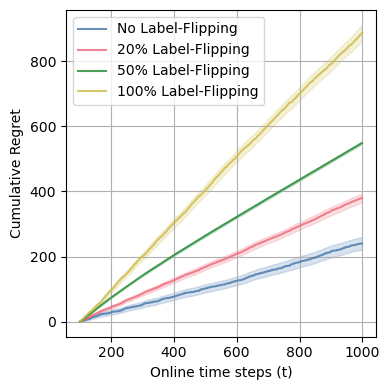

In [10]:
plot_risk_and_cumulative_risk("./", df)